In [9]:
from scipy import signal
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, model_selection, metrics


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import nets

import sys
sys.path.append('/home/marco/Projects/Doctorado/biosip_tools/')
from biosip_tools.eeg import utils
from biosip_tools.eeg import timeseries
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9669037


In [10]:
data_path = "/home/marco/data/eeg_data/"
os.listdir(data_path)

['EEG_7_2_RD.npy',
 'EEG_7_20_C.npy',
 'subjects_order_20_C.txt',
 'EEG_7_20_RD.npy',
 'subjects_order_8_RD.txt',
 'EEG_7_8_RD.npy',
 'subjects_order_20_RD.txt',
 'EEG_7_2_C.npy',
 'EEG_7_8_C.npy',
 'subjects_order_2_RD.txt',
 'subjects_order_8_C.txt',
 'subjects_order_2_C.txt']

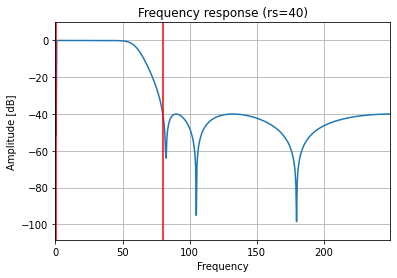

In [11]:
eeg_dlx = timeseries.EEGSeries(path = data_path + "EEG_7_2_RD.npy")
eeg_ctrl = timeseries.EEGSeries(path = data_path + "EEG_7_2_C.npy")
eeg = eeg_ctrl.append(eeg_dlx)
eeg.apply_cheby_filter(0.5,80, plot_response = True)
eeg.data = preprocessing.StandardScaler().fit_transform(eeg.data.reshape(eeg.data.shape[1], -1)).reshape(eeg.data.shape)


In [12]:
eeg.data.shape, eeg_dlx.data.shape, eeg_ctrl.data.shape

((98, 32, 75100), (30, 32, 75100), (68, 32, 75100))

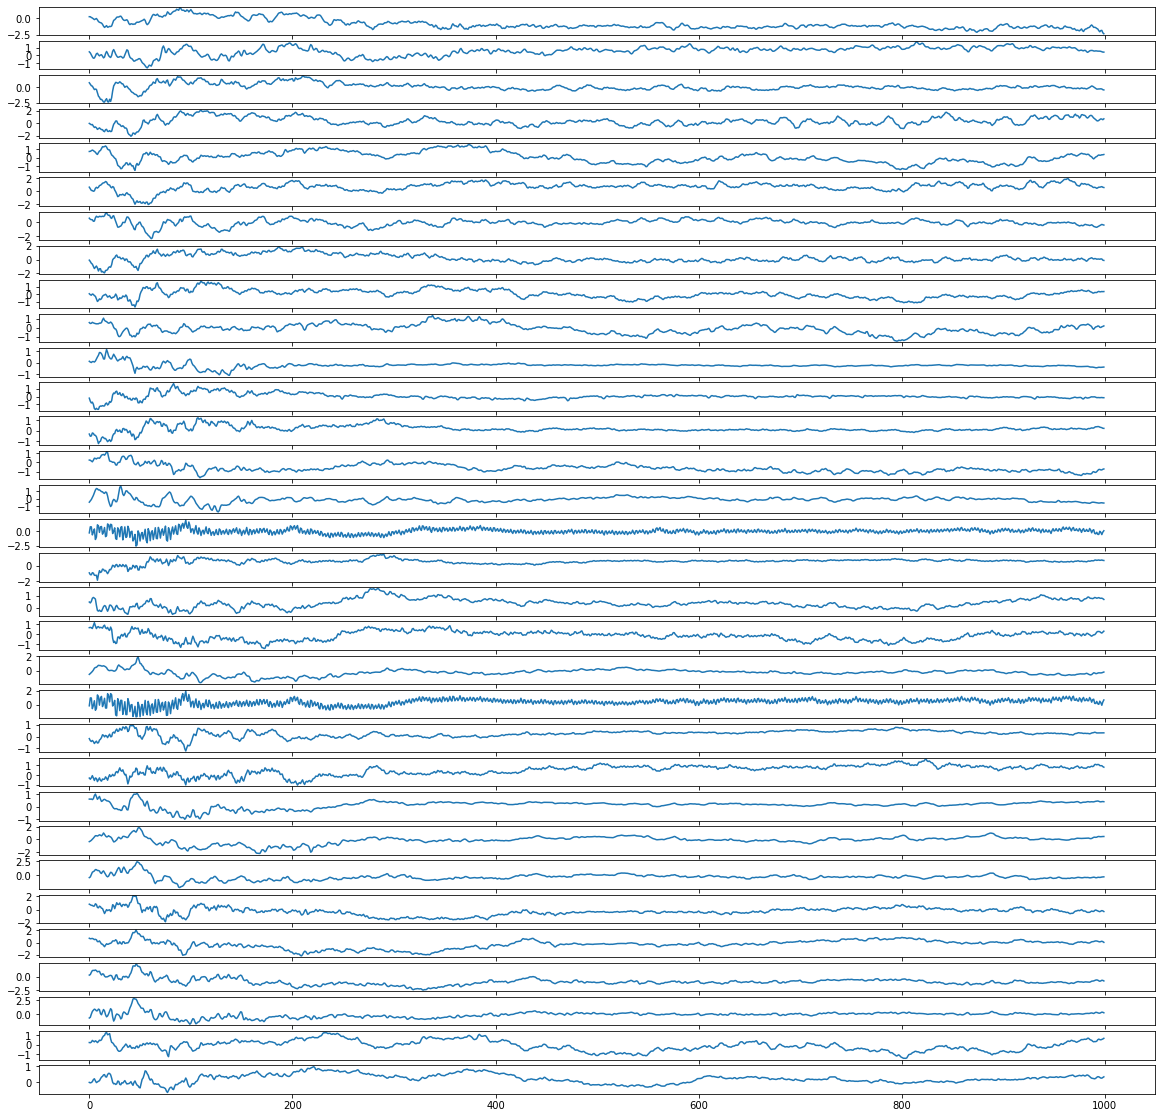

In [13]:
fig, axs = plt.subplots(eeg.data.shape[1], figsize=(20,20), sharex=True)
for idx_channel in range(eeg.data.shape[1]):
    axs[idx_channel].plot(eeg.data[0,idx_channel, :1000])
plt.show()

In [46]:
WINDOW_SIZE = 1
GEN_EPOCHS = 10
BATCH_SIZE = 1
generator = utils.window_data_loader(eeg, window_size = WINDOW_SIZE)
batch, labels, _ = generator.__next__()
_ , EEGChannels, EEGSamples = batch.shape
batch.shape

(32, 32, 500)

In [48]:
writer = SummaryWriter()
kf = model_selection.StratifiedKFold(n_splits=5)
# Ver si mejor dividir entre sujetos o a nivel de ventanas
labels = np.append(
    np.ones(eeg_dlx.data.shape[0]), np.zeros(eeg_ctrl.data.shape[0]))

weight = eeg_ctrl.data.shape[0] / eeg_dlx.data.shape[0]

for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(labels.shape), labels)):
    

    net = nets.CompleteNet(EEGChannels, EEGSamples).to("cuda")
    loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(
        [1, weight]).to("cuda"))  # Pos weight balance
    optimizer = Adam(net.parameters(), lr=0.001)

    trainEEG = timeseries.EEGSeries(data=eeg.data[train_index])
    train_labels = labels[train_index]

    testEEG = timeseries.EEGSeries(data=eeg.data[test_index])
    test_labels = labels[test_index]

    train_generator = utils.window_data_loader(
        trainEEG, window_size=WINDOW_SIZE, batch_size = BATCH_SIZE, labels=train_labels, epochs=GEN_EPOCHS, shuffle=True)
    losses = []

    for step, (batch, batch_labels, epoch) in enumerate(train_generator):

        optimizer.zero_grad()
        batch_labels = np.vstack(
            (1 - batch_labels, batch_labels)).T  # DLX = 0, CTRL = 1

        #weight_vector = batch_labels[:, 1] * weight

        batch = torch.from_numpy(batch).type(torch.FloatTensor).unsqueeze(
            1).to("cuda")  # Unsqueeze to add channel dimension
        batch_loss = loss(net(batch)[0], torch.from_numpy(
            batch_labels).to("cuda"))
        batch_loss.backward()
        optimizer.step()

        if epoch is not None:
            with torch.no_grad():
                test_results = []

                test_generator = utils.window_data_loader(testEEG, window_size=WINDOW_SIZE, labels=test_labels, epochs=1, return_subjects=True)
                for subject_batch, test_labels, _ in test_generator:
                    subject_batch = torch.from_numpy(subject_batch).type(
                        torch.FloatTensor).unsqueeze(1).to("cuda")

                    lbls = np.vstack((1 - test_labels, test_labels)).T
                    test_loss = loss(net(subject_batch)[0], torch.from_numpy(lbls).to("cuda")).cpu().numpy()


                    result = torch.sigmoid(
                        net(subject_batch)[0]).cpu().numpy().mean(axis=0)
                    test_results.append((test_labels[0], np.argmax(result, axis=0), np.mean(test_loss)))

                test_results = np.array(test_results)
                acc = metrics.accuracy_score(test_results[:,1], test_results[:,0])
                
                writer.add_scalars("Fold_{}".format(fold), {'train_loss': batch_loss.item(),
                                                            'test_loss': test_results[:,-1].mean(),
                                                            'accuracy': acc}, epoch)




KeyboardInterrupt: 